In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Load training data from CSV files and transpose them
X_train = np.loadtxt('train.csv', delimiter=',').T
Y_train = np.loadtxt('train_label.csv', delimiter=',').T

# Load test data from CSV files and transpose them
X_test = np.loadtxt('test.csv', delimiter=',').T
Y_test = np.loadtxt('test_label.csv', delimiter=',').T

# Print the shapes of the loaded datasets
print("shape of X_train :", X_train.shape)
print("shape of Y_train :", Y_train.shape)
print("shape of X_test :", X_test.shape)
print("shape of Y_test :", Y_test.shape)

shape of X_train : (784, 1000)
shape of Y_train : (10, 1000)
shape of X_test : (784, 350)
shape of Y_test : (10, 350)


In [3]:
# index = random.randrange(0, X_train.shape[1])
# plt.imshow(X_train[:, index].reshape(28, 28), cmap='gray')
# plt.show()

In [4]:
# Define activation functions
def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX / np.sum(expX, axis=0)

In [5]:
# Define derivatives of activation functions
def derivative_tanh(x):
    return 1 - np.power(np.tanh(x), 2)

def derivative_relu(x):
    return np.array(x > 0, dtype=np.float32)

def derivative_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def derivative_softmax(softmax_output, y_true):
    gradient = softmax_output - y_true
    return gradient

In [6]:
# Define dropout functions for regularization
def dropout_forward(x, p, training=True):
    if training:
        mask = (np.random.rand(*x.shape) > p) / (1 - p)
        return x * mask, mask
    else:
        return x

def dropout_backward(dout, mask):
    return dout * mask

In [7]:
# Initialize network parameters (weights and biases)
def initialize_parameters(n_x, n_h, n_y):
    w1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2
    }
    return parameters

In [8]:
# Perform forward propagation
def forward_propagation(x, parameters):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']

    z1 = np.dot(w1, x) + b1
    a1 = sigmoid(z1)  
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)

    forward_cache = {
        "z1": z1,
        "a1": a1,
        "z2": z2,
        "a2": a2
    }
    return forward_cache

In [9]:
# Compute the cost function (cross-entropy loss)
def cost_function(a2, y):
    m = y.shape[1]
    cost = -(1/m) * np.sum(y * np.log(a2))
    return cost

In [10]:
# Perform backward propagation
def backward_prop(x, y, parameters, forward_cache):
    w1 = parameters['w1']
    w2 = parameters['w2']

    a1 = forward_cache['a1']
    a2 = forward_cache['a2']

    m = x.shape[1]

    dz2 = a2 - y
    dw2 = (1/m) * np.dot(dz2, a1.T)
    db2 = (1/m) * np.sum(dz2, axis=1, keepdims=True)
    
    dz1 = (1/m) * np.dot(w2.T, dz2) * derivative_tanh(a1)  # Change to derivative_relu or derivative_sigmoid as needed
    dw1 = (1/m) * np.dot(dz1, x.T)
    db1 = (1/m) * np.sum(dz1, axis=1, keepdims=True)

    gradients = {
        "dw1": dw1,
        "db1": db1,
        "dw2": dw2,
        "db2": db2
    }
    return gradients

In [11]:
# Update parameters using gradient descent
def update_parameters(parameters, gradients, learning_rate):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']

    dw1 = gradients['dw1']
    db1 = gradients['db1']
    dw2 = gradients['dw2']
    db2 = gradients['db2']

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2

    parameters = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2
    }
    return parameters

# Update parameters using stochastic gradient descent
def update_parameters_sgd(parameters, gradients, learning_rate):
    updated_parameters = {}
    for key in parameters:
        updated_parameters[key] = parameters[key] - learning_rate * gradients["d" + key]
    return updated_parameters

# SGD with Momentum Implementation
def initialize_velocity(parameters):
    velocity = {}
    for key in parameters:
        velocity["v" + key] = np.zeros_like(parameters[key])
    return velocity

def update_parameters_with_momentum(parameters, gradients, velocity, learning_rate, beta):
    updated_parameters = {}
    for key in parameters:
        velocity["v" + key] = beta * velocity["v" + key] + (1 - beta) * gradients["d" + key]
        updated_parameters[key] = parameters[key] - learning_rate * velocity["v" + key]
    return updated_parameters, velocity

In [12]:
# Train the model
def model(x, y, n_h, learning_rate, iterations, optimizer="gd", beta=0.9):
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    if optimizer == "momentum":
        velocity = initialize_velocity(parameters)
    
    for i in range(iterations):
        forward_cache = forward_propagation(x, parameters)
        cost = cost_function(forward_cache['a2'], y)
        gradients = backward_prop(x, y, parameters, forward_cache)
        
        if optimizer == "gd":
            parameters = update_parameters(parameters, gradients, learning_rate)
        elif optimizer == "sgd":
            parameters = update_parameters_sgd(parameters, gradients, learning_rate)
        elif optimizer == "momentum":
            parameters, velocity = update_parameters_with_momentum(parameters, gradients, velocity, learning_rate, beta)
        
        cost_list.append(cost)
        
        if i % (iterations / 10) == 0:
            print("Cost after", i, "iterations is:", cost)
        
    return parameters, cost_list

In [13]:
# Set hyperparameters
iterations = 100
n_h = 1000
learning_rate = 0.02

Cost after 0 iterations is: 2.3342622630636067
Cost after 10 iterations is: 1.876437524857558
Cost after 20 iterations is: 1.5641219710805536
Cost after 30 iterations is: 1.339493083770191
Cost after 40 iterations is: 1.1737731561686748
Cost after 50 iterations is: 1.0480312701352057
Cost after 60 iterations is: 0.9500081390357107
Cost after 70 iterations is: 0.8717092195817913
Cost after 80 iterations is: 0.8078524821072953
Cost after 90 iterations is: 0.7548512351081375
Cost after 0 iterations is: 2.3070571679712675
Cost after 10 iterations is: 1.8371540747167305
Cost after 20 iterations is: 1.525443426425777
Cost after 30 iterations is: 1.3042826638730567
Cost after 40 iterations is: 1.1425833650404558
Cost after 50 iterations is: 1.0206186152698526
Cost after 60 iterations is: 0.9259126626770754
Cost after 70 iterations is: 0.8504596723617094
Cost after 80 iterations is: 0.7890094916503686
Cost after 90 iterations is: 0.7379818684396037
Cost after 0 iterations is: 2.310529821355230

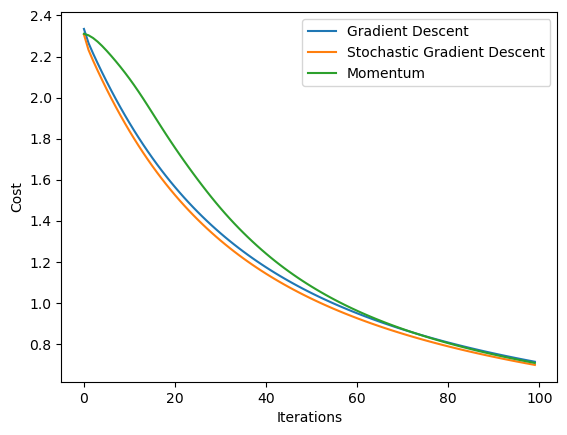

Accuracy of Train Dataset with Gradient Descent: 89.60000000000001 %
Accuracy of Test Dataset with Gradient Descent: 85.14 %
Accuracy of Train Dataset with SGD: 89.8 %
Accuracy of Test Dataset with SGD: 83.71 %
Accuracy of Train Dataset with Momentum: 88.1 %
Accuracy of Test Dataset with Momentum: 84.57 %


In [14]:
# Train model using different optimizers
Parameters_gd, Cost_list_gd = model(X_train, Y_train, n_h=n_h, learning_rate=learning_rate, iterations=iterations, optimizer="gd")
Parameters_sgd, Cost_list_sgd = model(X_train, Y_train, n_h=n_h, learning_rate=learning_rate, iterations=iterations, optimizer="sgd")
Parameters_momentum, Cost_list_momentum = model(X_train, Y_train, n_h=n_h, learning_rate=learning_rate, iterations=iterations, optimizer="momentum")

# Plot the cost over iterations for different optimizers
t = np.arange(0, iterations)
plt.plot(t, Cost_list_gd, label="Gradient Descent")
plt.plot(t, Cost_list_sgd, label="Stochastic Gradient Descent")
plt.plot(t, Cost_list_momentum, label="Momentum")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()

# Compute the accuracy of the model
def accuracy(inp, labels, parameters):
    forward_cache = forward_propagation(inp, parameters)
    a_out = forward_cache['a2']
    a_out = np.argmax(a_out, 0)  # Get predicted labels
    labels = np.argmax(labels, 0)
    acc = np.mean(a_out == labels) * 100
    return acc

print("Accuracy of Train Dataset with Gradient Descent:", accuracy(X_train, Y_train, Parameters_gd), "%")
print("Accuracy of Test Dataset with Gradient Descent:", round(accuracy(X_test, Y_test, Parameters_gd), 2), "%")

print("Accuracy of Train Dataset with SGD:", accuracy(X_train, Y_train, Parameters_sgd), "%")
print("Accuracy of Test Dataset with SGD:", round(accuracy(X_test, Y_test, Parameters_sgd), 2), "%")

print("Accuracy of Train Dataset with Momentum:", accuracy(X_train, Y_train, Parameters_momentum), "%")
print("Accuracy of Test Dataset with Momentum:", round(accuracy(X_test, Y_test, Parameters_momentum), 2), "%")

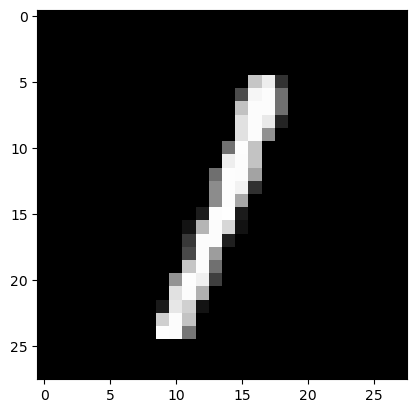

Our model (Gradient Descent) says it is: 1


In [15]:
# Visualize a random test sample and its predicted label
idx = int(random.randrange(0, X_test.shape[1]))
plt.imshow(X_test[:, idx].reshape((28, 28)), cmap='gray')
plt.show()

cache = forward_propagation(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters_gd)
a_pred = cache['a2']
a_pred = np.argmax(a_pred, 0)
print("Our model (Gradient Descent) says it is:", a_pred[0])


In [16]:
# Define L2 regularization
def compute_l2_cost(parameters, lambd):
    l2_cost = 0
    for key in parameters:
        if 'w' in key:
            l2_cost += np.sum(np.square(parameters[key]))
    return lambd / 2 * l2_cost

# Modify cost function to include L2 regularization
def cost_function(a2, y, parameters, lambd=0):
    m = y.shape[1]
    cross_entropy_cost = -(1/m) * np.sum(y * np.log(a2))
    l2_cost = compute_l2_cost(parameters, lambd)
    cost = cross_entropy_cost + l2_cost
    return cost

# Train the model with different architectures and parameters
def model(x, y, n_h, learning_rate, iterations, activation_fn, optimizer="gd", lambd=0, keep_prob=1, beta=0.9):
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    if optimizer == "momentum":
        velocity = initialize_velocity(parameters)
    
    for i in range(iterations):
        if keep_prob < 1:
            x, mask = dropout_forward(x, keep_prob)

        forward_cache = forward_propagation(x, parameters)
        cost = cost_function(forward_cache['a2'], y, parameters, lambd)
        gradients = backward_prop(x, y, parameters, forward_cache)
        
        if optimizer == "gd":
            parameters = update_parameters(parameters, gradients, learning_rate)
        elif optimizer == "sgd":
            parameters = update_parameters_sgd(parameters, gradients, learning_rate)
        elif optimizer == "momentum":
            parameters, velocity = update_parameters_with_momentum(parameters, gradients, velocity, learning_rate, beta)
        
        cost_list.append(cost)
        
        if i % (iterations / 10) == 0:
            print("Cost after", i, "iterations is:", cost)
        
    return parameters, cost_list

In [17]:
# Define a function to run experiments with different configurations
def run_experiments(configs):
    results = []
    for config in configs:
        print(f"Running experiment with config: {config}")
        parameters, cost_list = model(
            X_train, Y_train,
            n_h=config["n_h"],
            learning_rate=config["learning_rate"],
            iterations=config["iterations"],
            activation_fn=config["activation_fn"],
            optimizer=config["optimizer"],
            lambd=config["lambd"],
            keep_prob=config["keep_prob"]
        )
        train_accuracy = accuracy(X_train, Y_train, parameters)
        test_accuracy = accuracy(X_test, Y_test, parameters)
        results.append({
            "config": config,
            "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy,
            "cost_list": cost_list
        })
    return results

# Define the configurations to experiment with
configs = [
    {"n_h": 50, "learning_rate": 0.01, "iterations": 1000, "activation_fn": "sigmoid", "optimizer": "gd", "lambd": 0, "keep_prob": 1},
    {"n_h": 50, "learning_rate": 0.01, "iterations": 1000, "activation_fn": "relu", "optimizer": "sgd", "lambd": 0.1, "keep_prob": 0.8},
    {"n_h": 50, "learning_rate": 0.01, "iterations": 1000, "activation_fn": "tanh", "optimizer": "momentum", "lambd": 0.1, "keep_prob": 1},
    {"n_h": 100, "learning_rate": 0.02, "iterations": 1000, "activation_fn": "sigmoid", "optimizer": "gd", "lambd": 0, "keep_prob": 1},
    {"n_h": 100, "learning_rate": 0.02, "iterations": 1000, "activation_fn": "relu", "optimizer": "sgd", "lambd": 0.1, "keep_prob": 0.8},
    {"n_h": 100, "learning_rate": 0.02, "iterations": 1000, "activation_fn": "tanh", "optimizer": "momentum", "lambd": 0.1, "keep_prob": 1},
]

Running experiment with config: {'n_h': 50, 'learning_rate': 0.01, 'iterations': 1000, 'activation_fn': 'sigmoid', 'optimizer': 'gd', 'lambd': 0, 'keep_prob': 1}
Cost after 0 iterations is: 2.306610791236934
Cost after 100 iterations is: 2.1556041537606623
Cost after 200 iterations is: 1.9984415367844905
Cost after 300 iterations is: 1.8833519579197295
Cost after 400 iterations is: 1.8149171453437498
Cost after 500 iterations is: 1.7709644879461408
Cost after 600 iterations is: 1.7351550953314119
Cost after 700 iterations is: 1.7034647780554009
Cost after 800 iterations is: 1.672532184639094
Cost after 900 iterations is: 1.6448101985564572
Running experiment with config: {'n_h': 50, 'learning_rate': 0.01, 'iterations': 1000, 'activation_fn': 'relu', 'optimizer': 'sgd', 'lambd': 0.1, 'keep_prob': 0.8}
Cost after 0 iterations is: 2.501078698294834


/var/folders/ss/tcs3hqt15kz3s6rynljqf7kc0000gn/T/ipykernel_36526/1562172809.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Cost after 100 iterations is: 2.496029254726419
Cost after 200 iterations is: 2.4958264782948985
Cost after 300 iterations is: 2.4958307087296134
Cost after 400 iterations is: 2.4958354736134996
Cost after 500 iterations is: 2.4958369703464744
Cost after 600 iterations is: 2.49583738359261
Cost after 700 iterations is: 2.495837495363394
Cost after 800 iterations is: 2.4958375257127234
Cost after 900 iterations is: 2.4958375340364563
Running experiment with config: {'n_h': 50, 'learning_rate': 0.01, 'iterations': 1000, 'activation_fn': 'tanh', 'optimizer': 'momentum', 'lambd': 0.1, 'keep_prob': 1}
Cost after 0 iterations is: 2.504721166993686
Cost after 100 iterations is: 2.4010027491740193
Cost after 200 iterations is: 2.2893902587817863
Cost after 300 iterations is: 2.207202074870291
Cost after 400 iterations is: 2.1652024797001777
Cost after 500 iterations is: 2.148832653059546
Cost after 600 iterations is: 2.1534674615619616
Cost after 700 iterations is: 2.166924914770707
Cost after

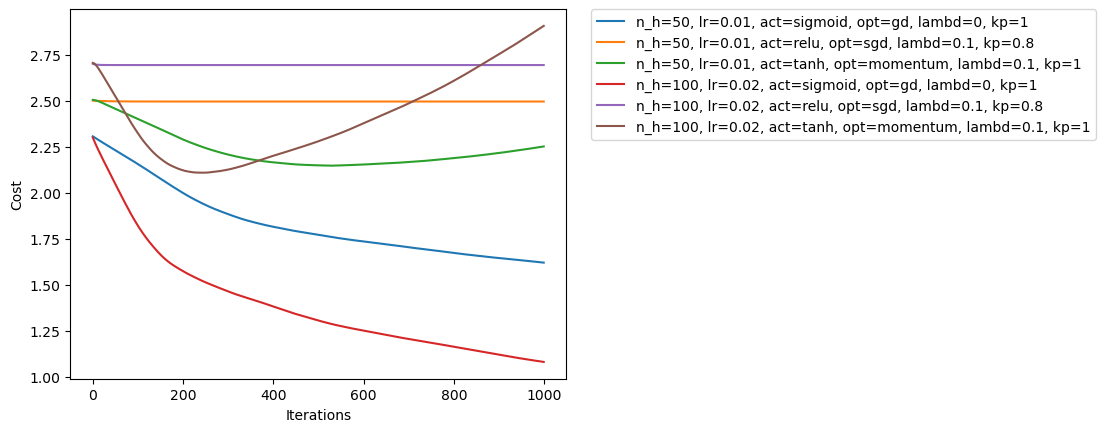

Config: {'n_h': 50, 'learning_rate': 0.01, 'iterations': 1000, 'activation_fn': 'sigmoid', 'optimizer': 'gd', 'lambd': 0, 'keep_prob': 1}
Train Accuracy: 60.8%
Test Accuracy: 57.714285714285715%


Config: {'n_h': 50, 'learning_rate': 0.01, 'iterations': 1000, 'activation_fn': 'relu', 'optimizer': 'sgd', 'lambd': 0.1, 'keep_prob': 0.8}
Train Accuracy: 9.6%
Test Accuracy: 12.0%


Config: {'n_h': 50, 'learning_rate': 0.01, 'iterations': 1000, 'activation_fn': 'tanh', 'optimizer': 'momentum', 'lambd': 0.1, 'keep_prob': 1}
Train Accuracy: 61.0%
Test Accuracy: 56.85714285714286%


Config: {'n_h': 100, 'learning_rate': 0.02, 'iterations': 1000, 'activation_fn': 'sigmoid', 'optimizer': 'gd', 'lambd': 0, 'keep_prob': 1}
Train Accuracy: 74.0%
Test Accuracy: 69.14285714285714%


Config: {'n_h': 100, 'learning_rate': 0.02, 'iterations': 1000, 'activation_fn': 'relu', 'optimizer': 'sgd', 'lambd': 0.1, 'keep_prob': 0.8}
Train Accuracy: 13.5%
Test Accuracy: 14.000000000000002%


Config: {'n_h': 100, 

In [18]:
# Run the experiments
results = run_experiments(configs)

# Plot and compare the results
for result in results:
    config = result["config"]
    cost_list = result["cost_list"]
    label = f'n_h={config["n_h"]}, lr={config["learning_rate"]}, act={config["activation_fn"]}, opt={config["optimizer"]}, lambd={config["lambd"]}, kp={config["keep_prob"]}'
    plt.plot(cost_list, label=label)

plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Print accuracy results
for result in results:
    config = result["config"]
    print(f'Config: {config}')
    print(f'Train Accuracy: {result["train_accuracy"]}%')
    print(f'Test Accuracy: {result["test_accuracy"]}%')
    print("\n")
